In [1]:
!date

Sun Feb 23 14:17:30 PST 2020


# Level 1 Plotting

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [3]:
isoform = anndata.read_h5ad("cell_ranger_annotation/isoform.h5ad")
gene =    anndata.read_h5ad("cell_ranger_annotation/gene.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


# Plot intro

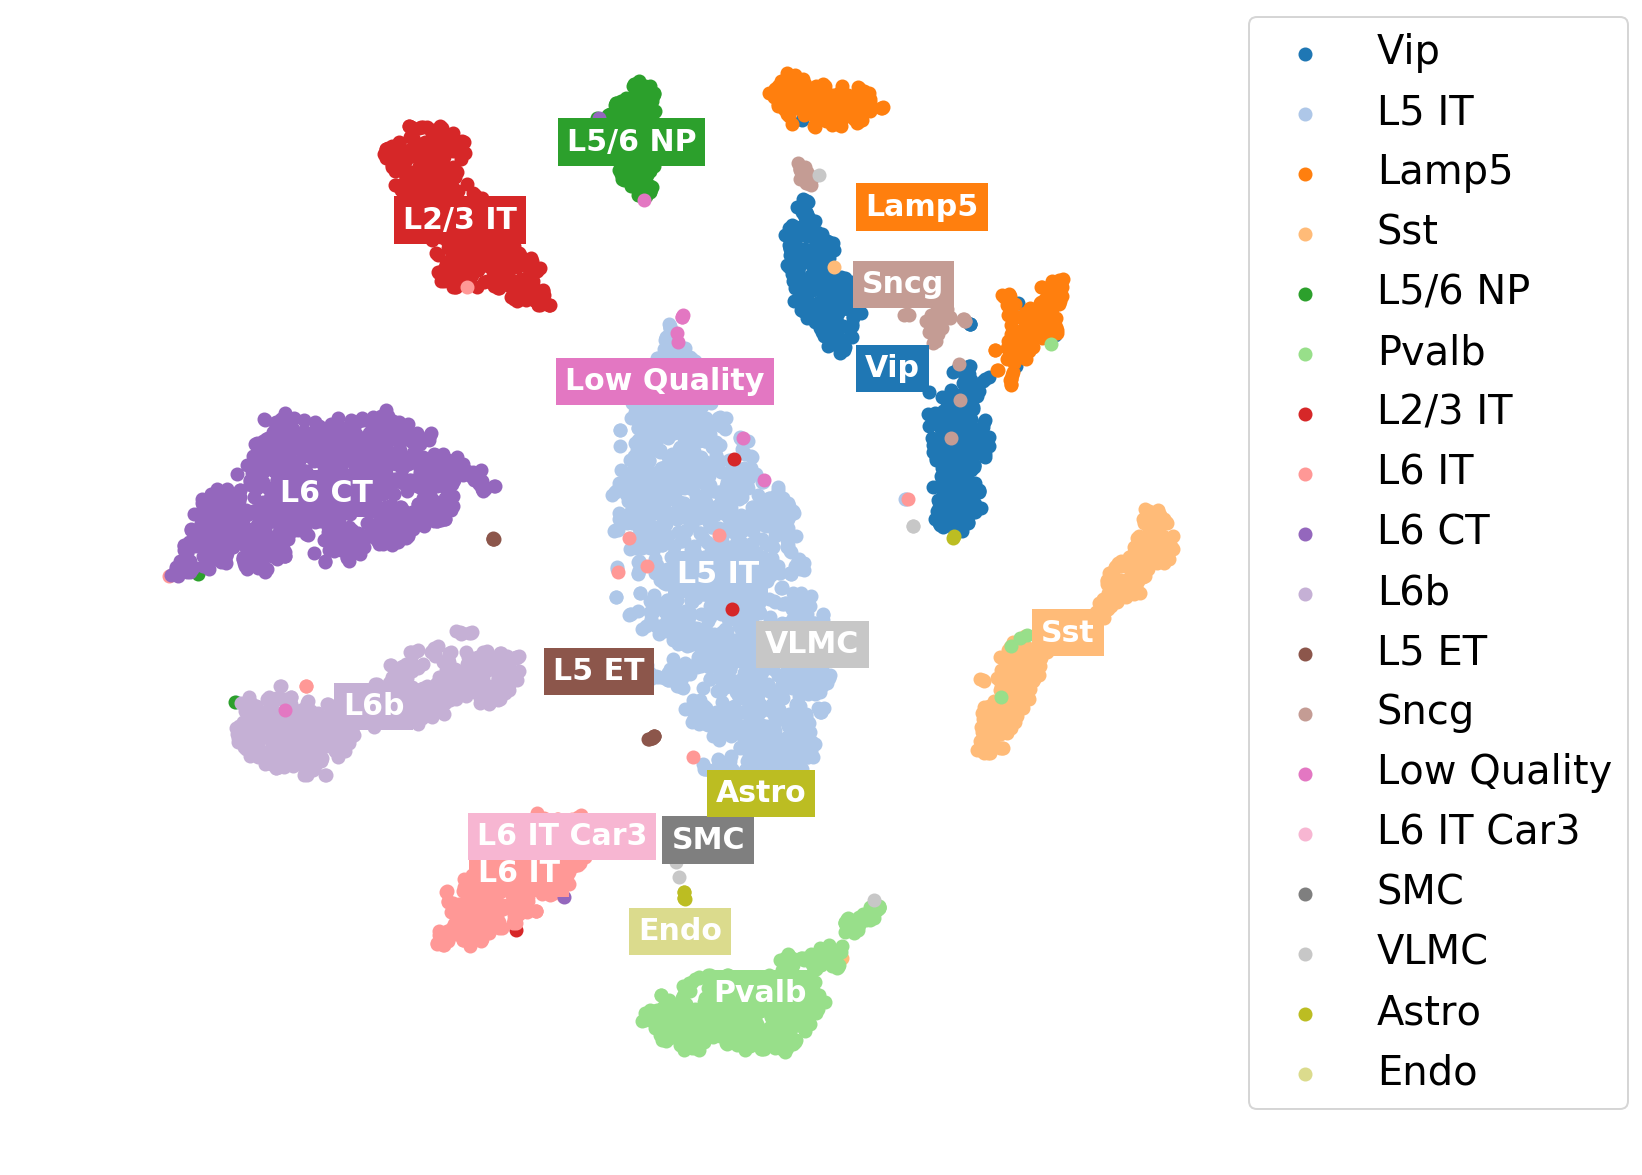

In [22]:
fig, ax = plt.subplots(figsize=(10,10))

c = gene.obs["subclass_label"].unique().astype(str)
cmap = cm.get_cmap("tab20")

for idx, cluster in enumerate(c):
    XX = gene[gene.obs.subclass_label == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    if cluster == "Endo": y = y-10
    if cluster == "SMC": y = y+5; x=x+5
    ax.scatter(x, y, color = cmap(idx), label=cluster)
    ax.annotate(cluster, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.show()

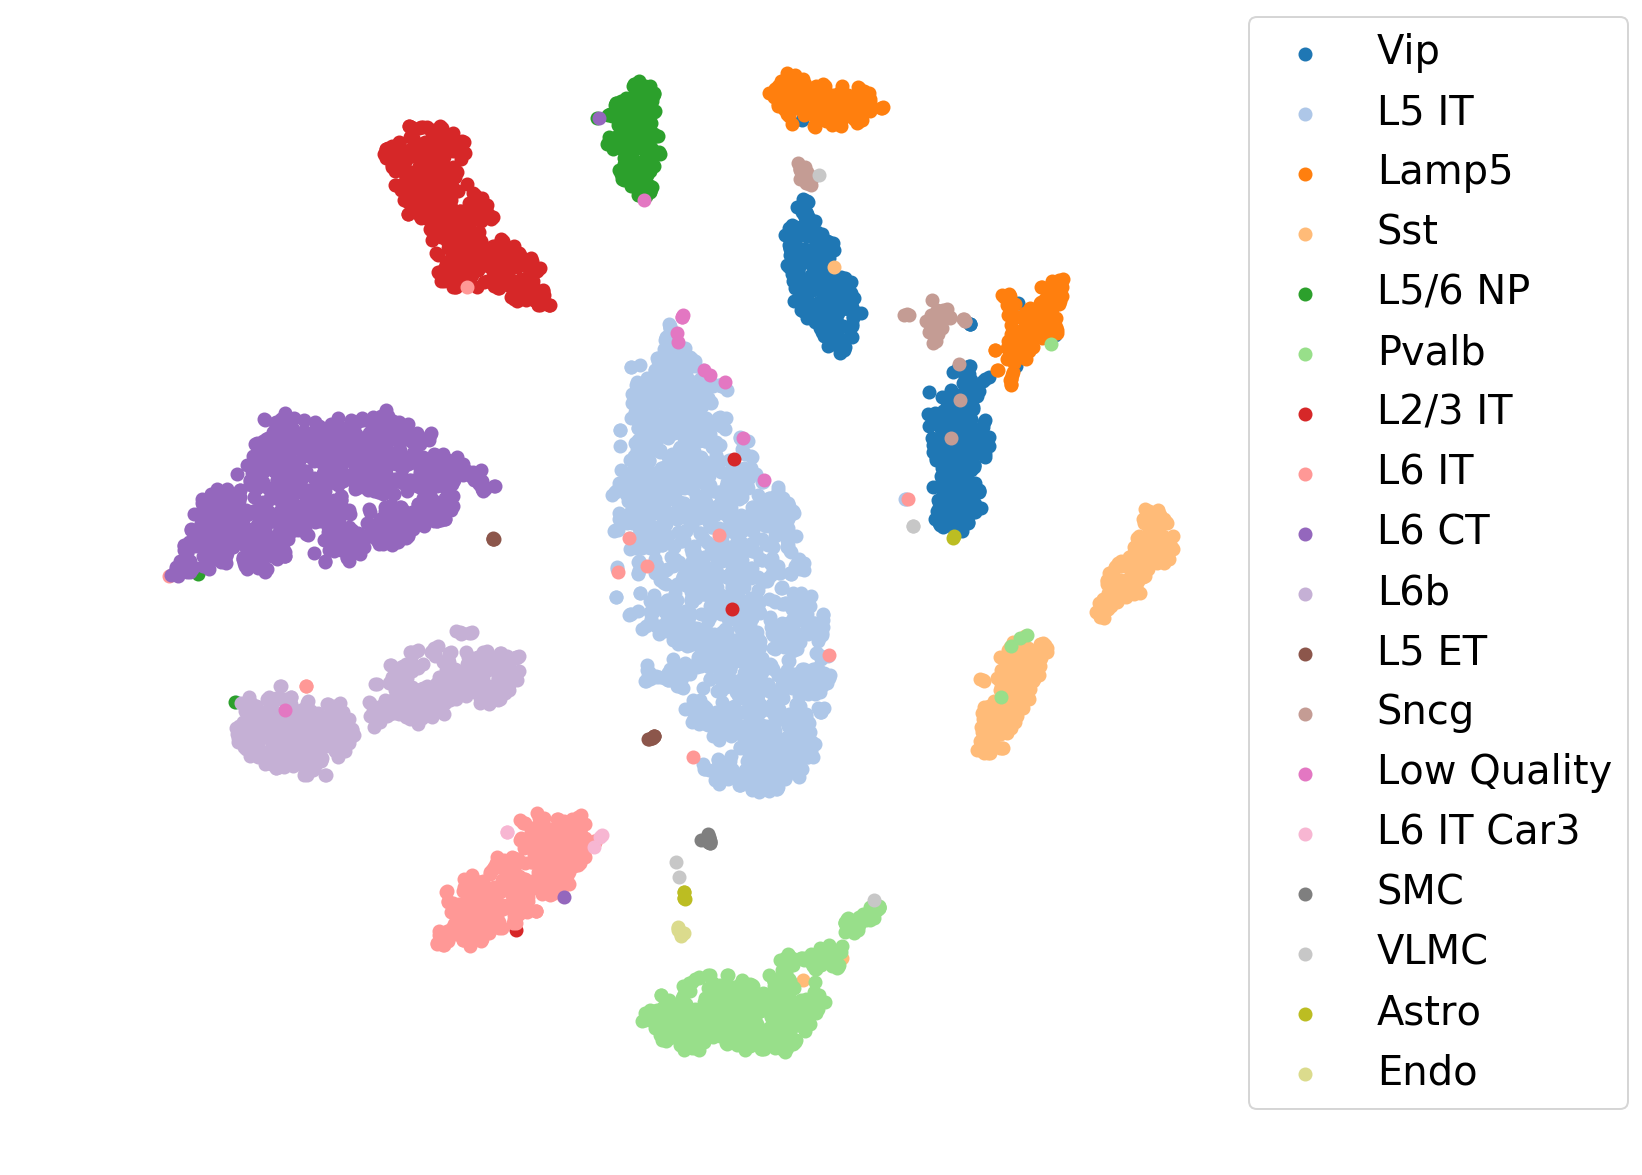

In [188]:
fig, ax = plt.subplots(figsize=(10,10))

c = gene.obs["subclass_label"].unique().astype(str)
cmap = cm.get_cmap("tab20")

for idx, cluster in enumerate(c):
    XX = gene[gene.obs.subclass_label == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    if cluster == "Endo": y = y-10
    if cluster == "SMC": y = y+5; x=x+5
    ax.scatter(x, y, color = cmap(idx), label=cluster)
    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.show()

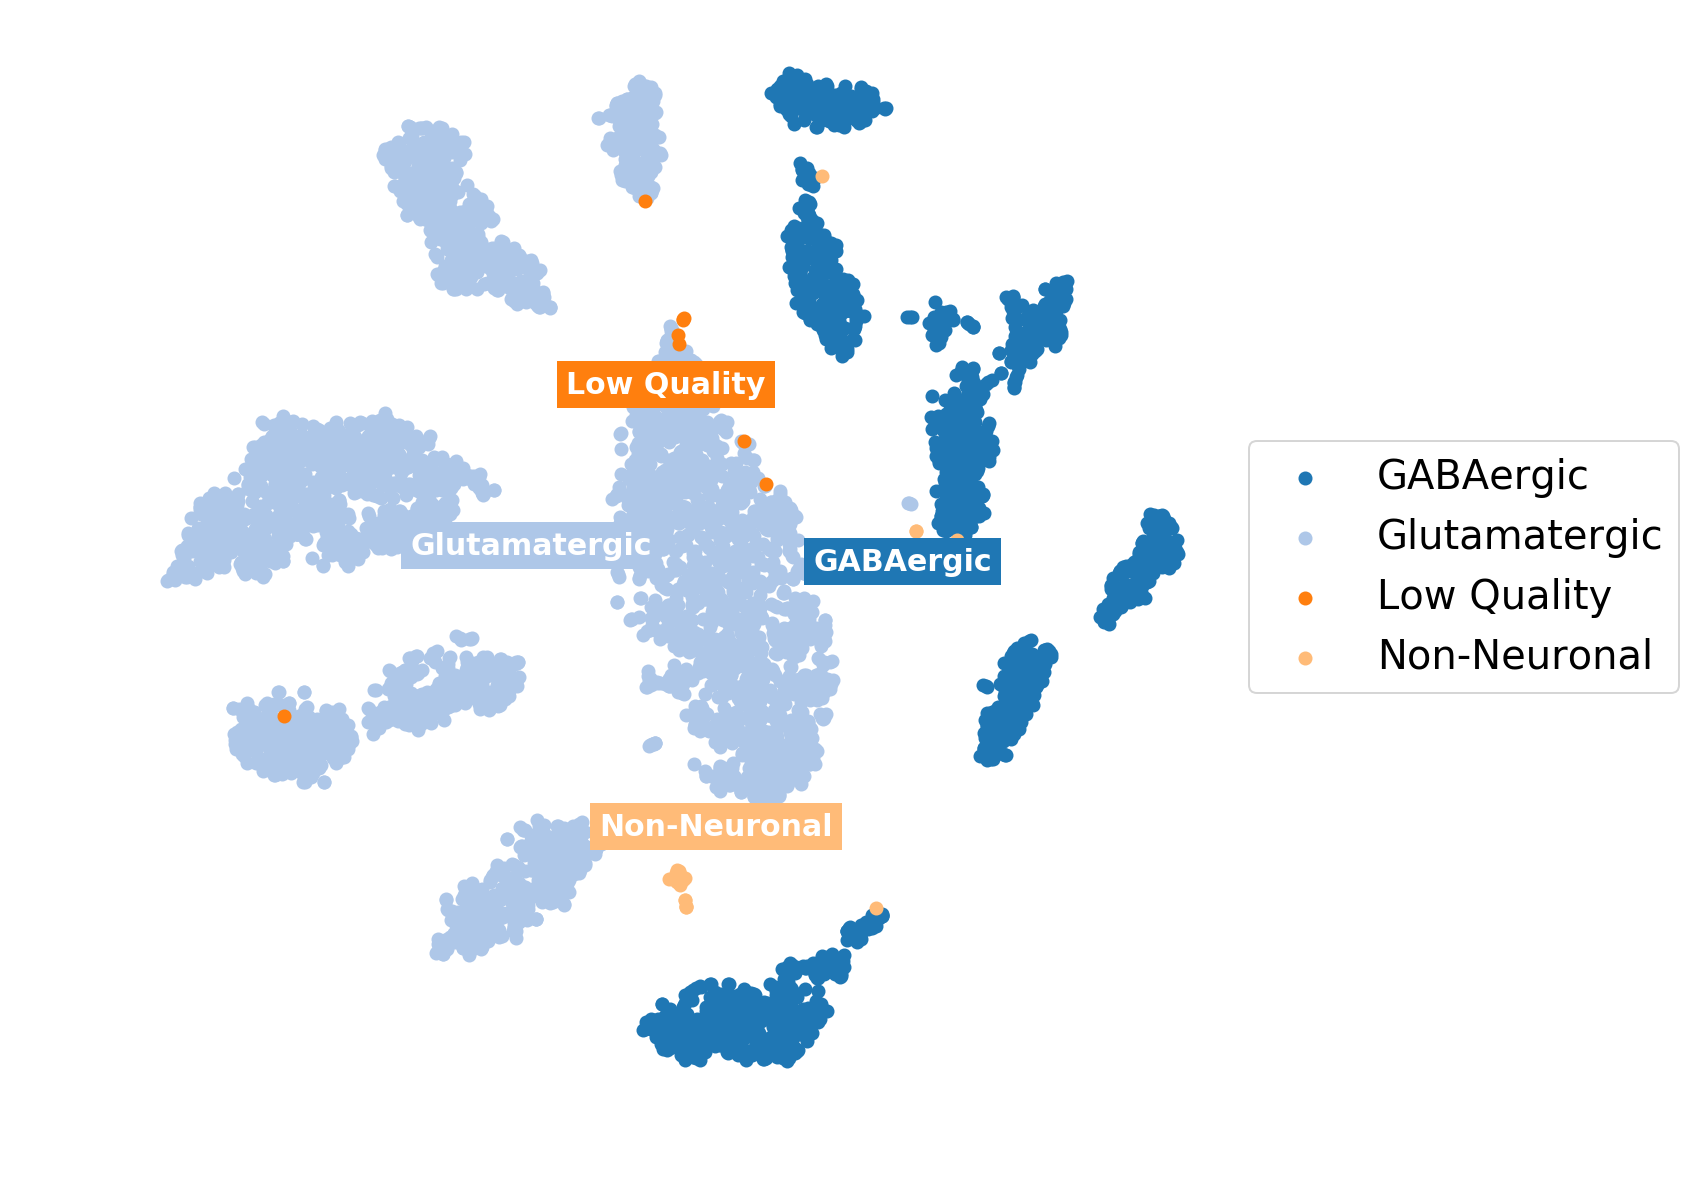

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

c = gene.obs["class_label"].unique()
cmap = cm.get_cmap("tab20")

for idx, cluster in enumerate(c):
    XX = gene[gene.obs.class_label == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    
    ax.scatter(x, y, color = cmap(idx), label=cluster)
    ax.annotate(cluster, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.show()

# Subclass examples

In [198]:
gene.obs.subclass_label.value_counts()

L5 IT          1560
L6 CT           904
L6b             568
Vip             555
Pvalb           496
L2/3 IT         482
L6 IT           395
Sst             391
Lamp5           348
L5/6 NP         207
Sncg             71
SMC              17
Low Quality      12
L5 ET            12
Endo              7
Astro             7
VLMC              6
L6 IT Car3        5
Name: subclass_label, dtype: int64

good examples: 
- (Arpp21-206, L2/3 IT), 
- (CCdc12-210, L6 CT) 
- (Pde4d-209, L6 CT) 
- (Pde4d-211, L6 CT) 
- (Satb1-208, Sst) 
- (Fgf13-203, Lamp5) 
- (Igsf11-201, Lamp5) 
- (Unc5c-208, L5/6 NP) 
- (Erc2-207, L6 IT)
- (Erc2-207, L2/3 IT)
- (TPM1-216, L6 IT)
- (Cldnd1-205, L6b)
- (Pde4d-211, L6b)
- (Tmem243-201, L6b)
- (Enpp2-207, L2/3 IT)

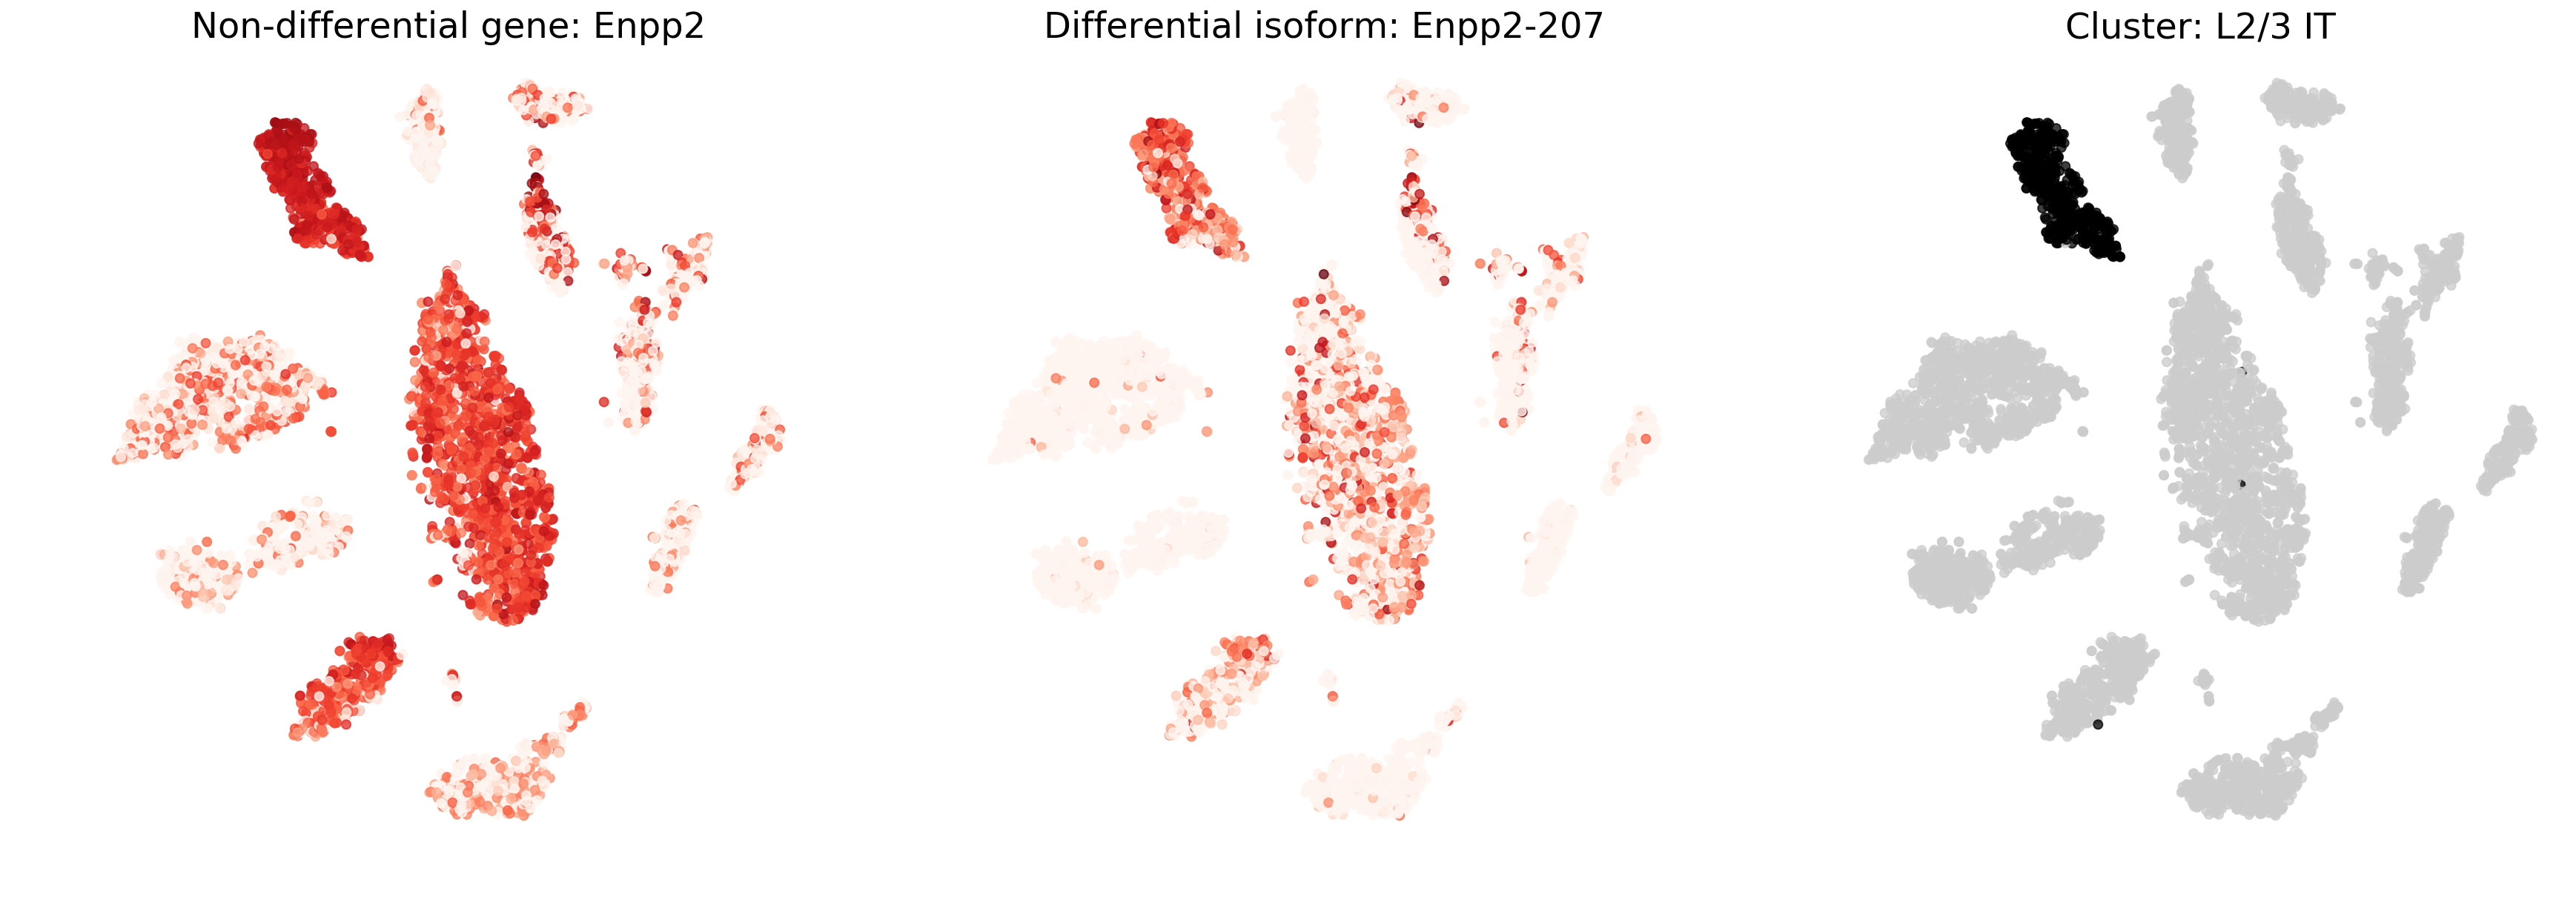

In [275]:
specific_gene = "Enpp2"
specific_isoform = specific_gene + "-" + "207"
specific_cluster = "L2/3 IT"

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"]).reshape(-1)
cmap="Reds"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Reds"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_label"]==specific_cluster
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Cluster: {}".format(specific_cluster))
plt.show()

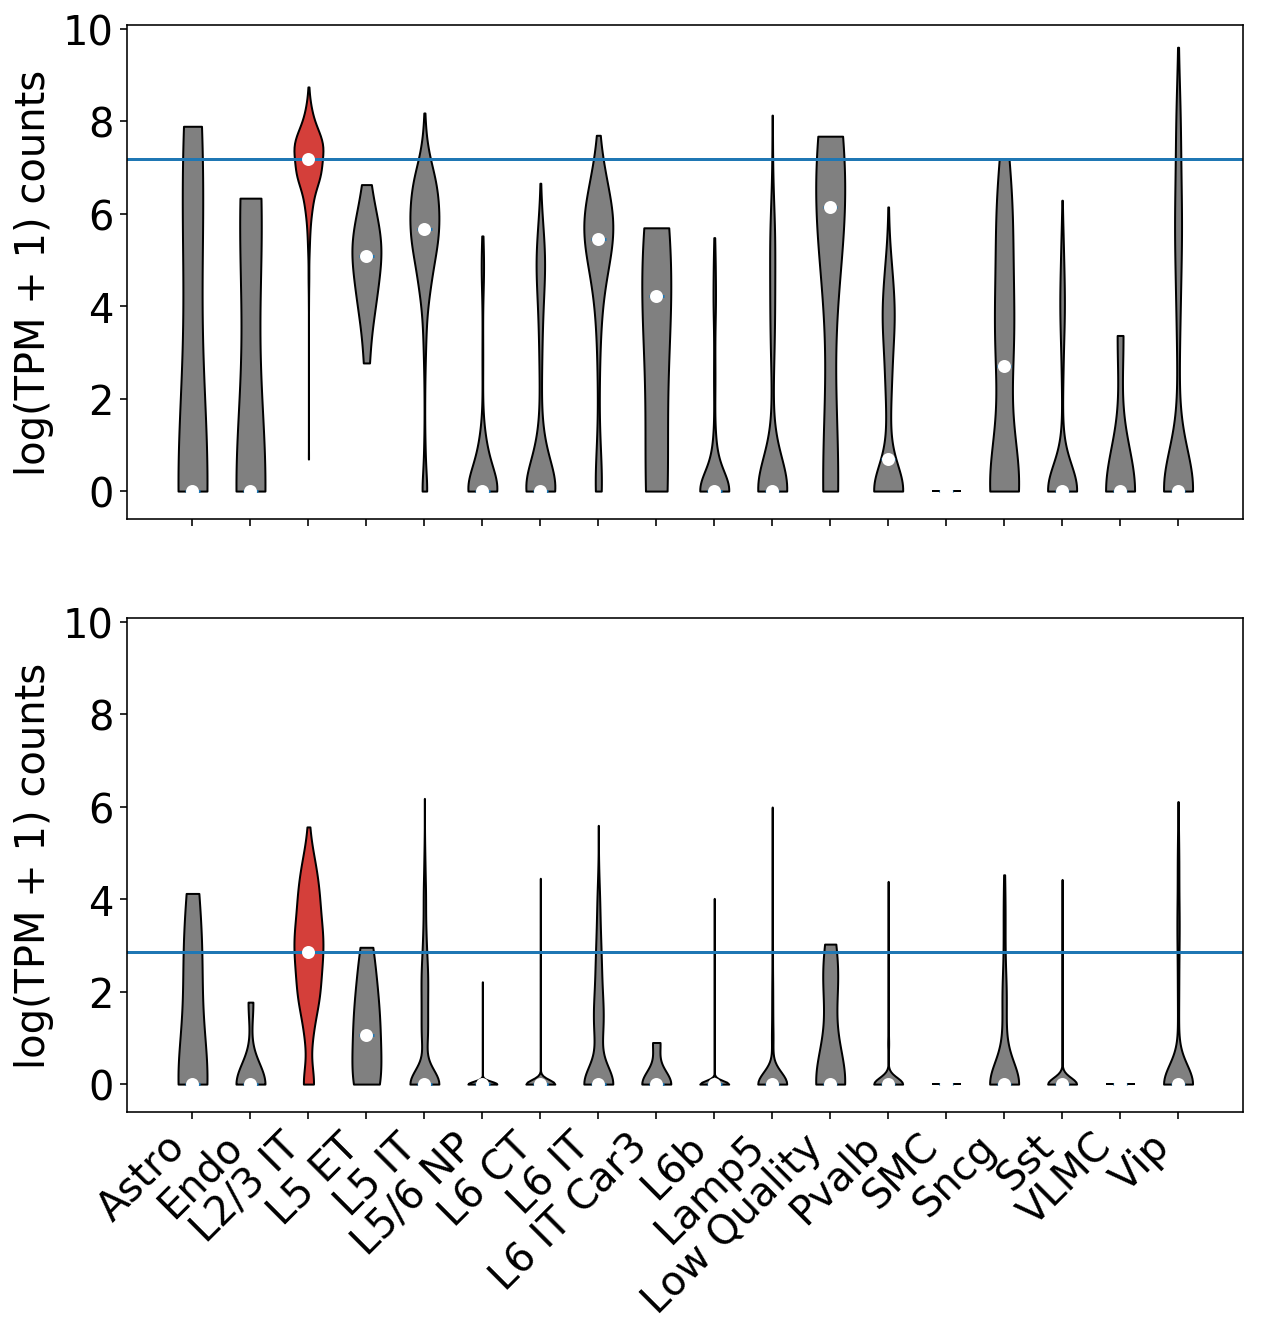

In [280]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2, sharex=True)

unique = np.unique(gene.obs.subclass_label)
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
#######3# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.subclass_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"]).reshape(-1).tolist())

parts = ax[0].violinplot(x, showmedians=True, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')

medians = [np.median(i) for i in x]
ax[0].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

ax[0].axhline(y=medians[midx])
ax[0].set_ylabel("log(TPM + 1) counts")
######## Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.subclass_label==c][:,isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax[1].violinplot(x, showmedians=True, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')

medians = [np.median(i) for i in x]
ax[1].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)
ax[1].axhline(y=medians[midx])
ax[1].set_xticks(lidx)
ax[1].set_xticklabels(labels, rotation=45, ha="right")
ax[1].set_ylabel("log(TPM + 1) counts")
ymin, ymax = ax[0].get_ylim()
ax[1].set_ylim((ymin, ymax))
plt.show()

# Class examples

In [258]:
gene.obs.class_label.value_counts()

Glutamatergic    4133
GABAergic        1861
Non-Neuronal       37
Low Quality        12
Name: class_label, dtype: int64

- (H3f3b-204, Glutamatergic)
- (Magi2-202, Glutamatergic)
- (Pclo-204, Glutamatergic)

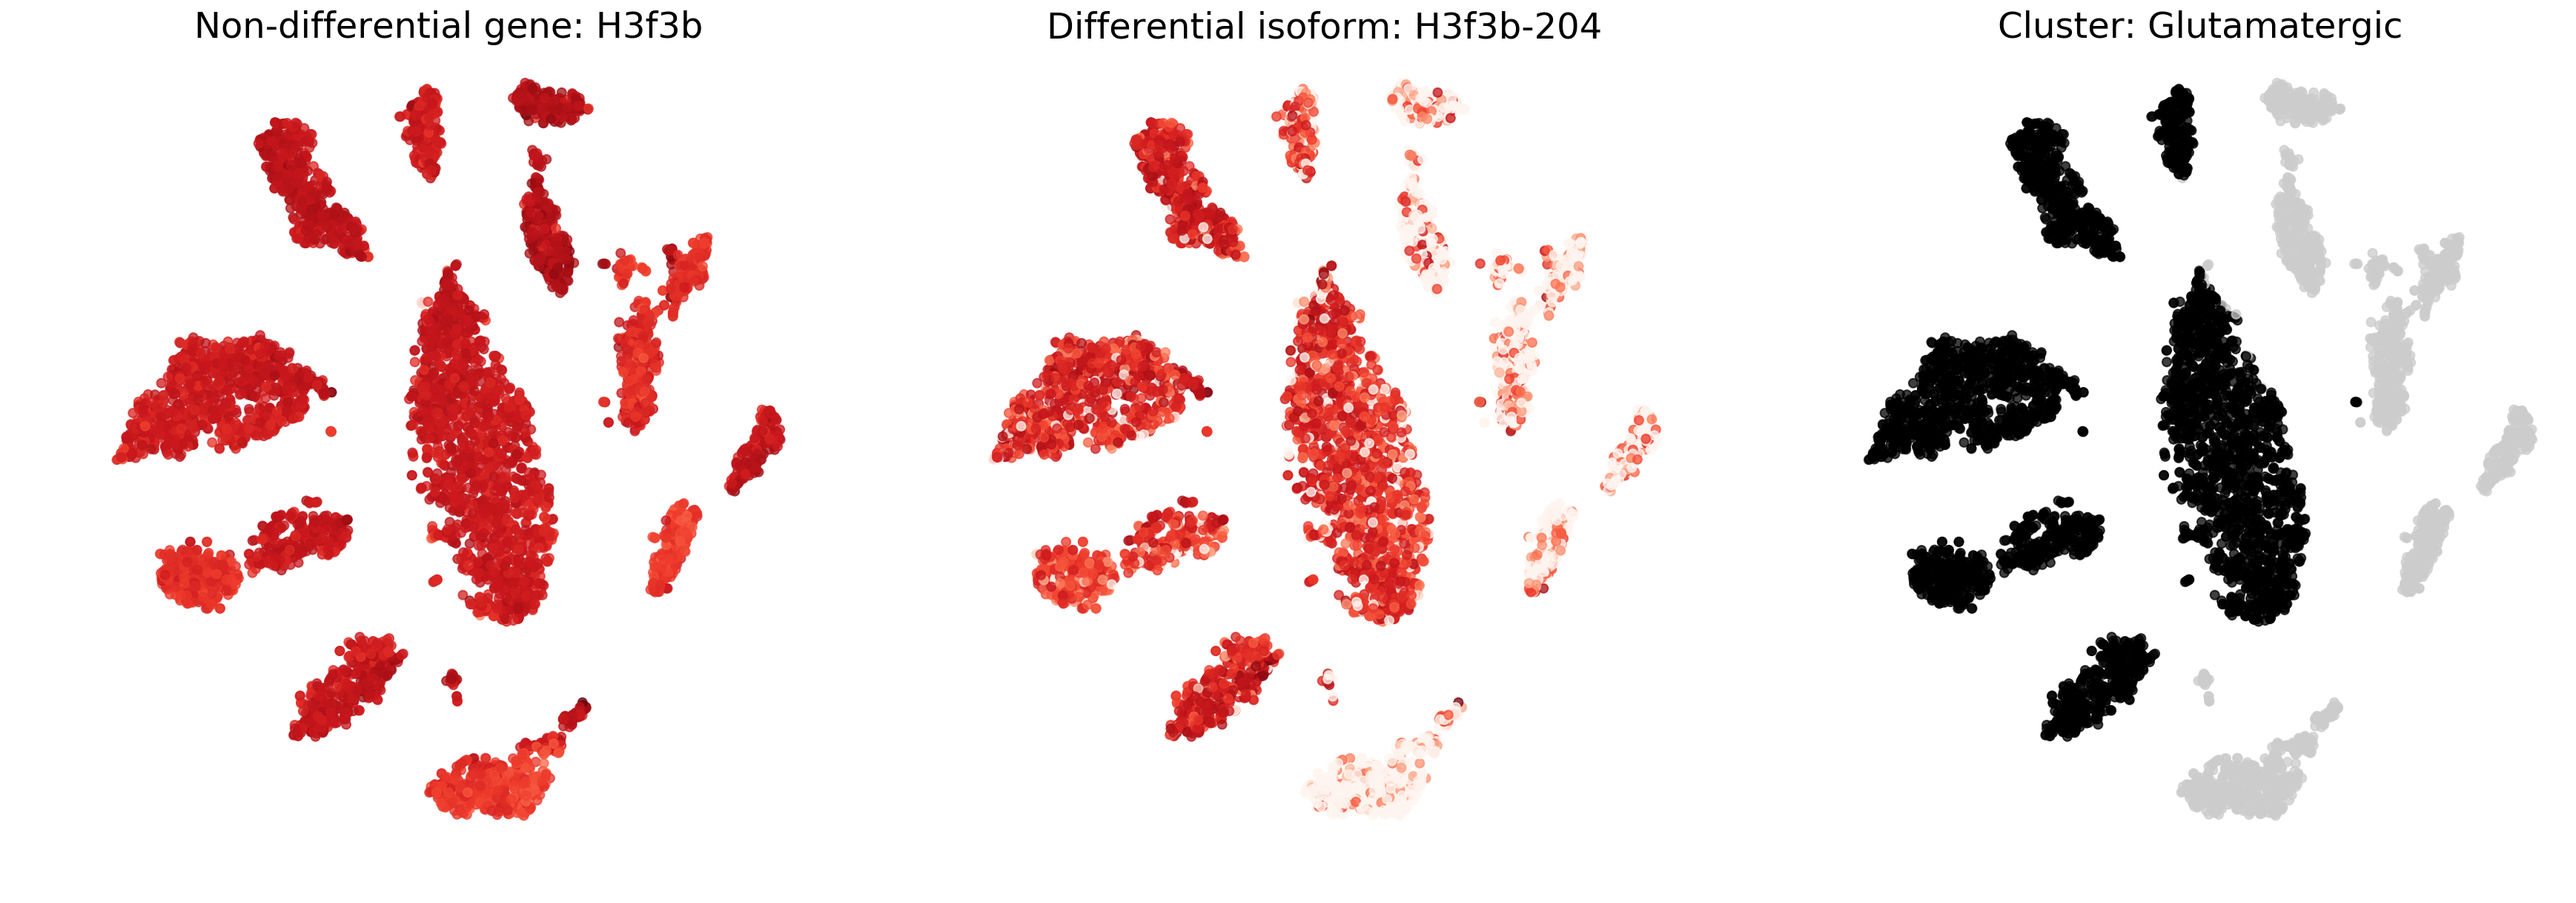

In [282]:
specific_gene = "H3f3b"
specific_isoform = specific_gene + "-" + "204"
specific_cluster = "Glutamatergic"

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"]).reshape(-1)
cmap="Reds"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Reds"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["class_label"]==specific_cluster
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Cluster: {}".format(specific_cluster))
plt.show()

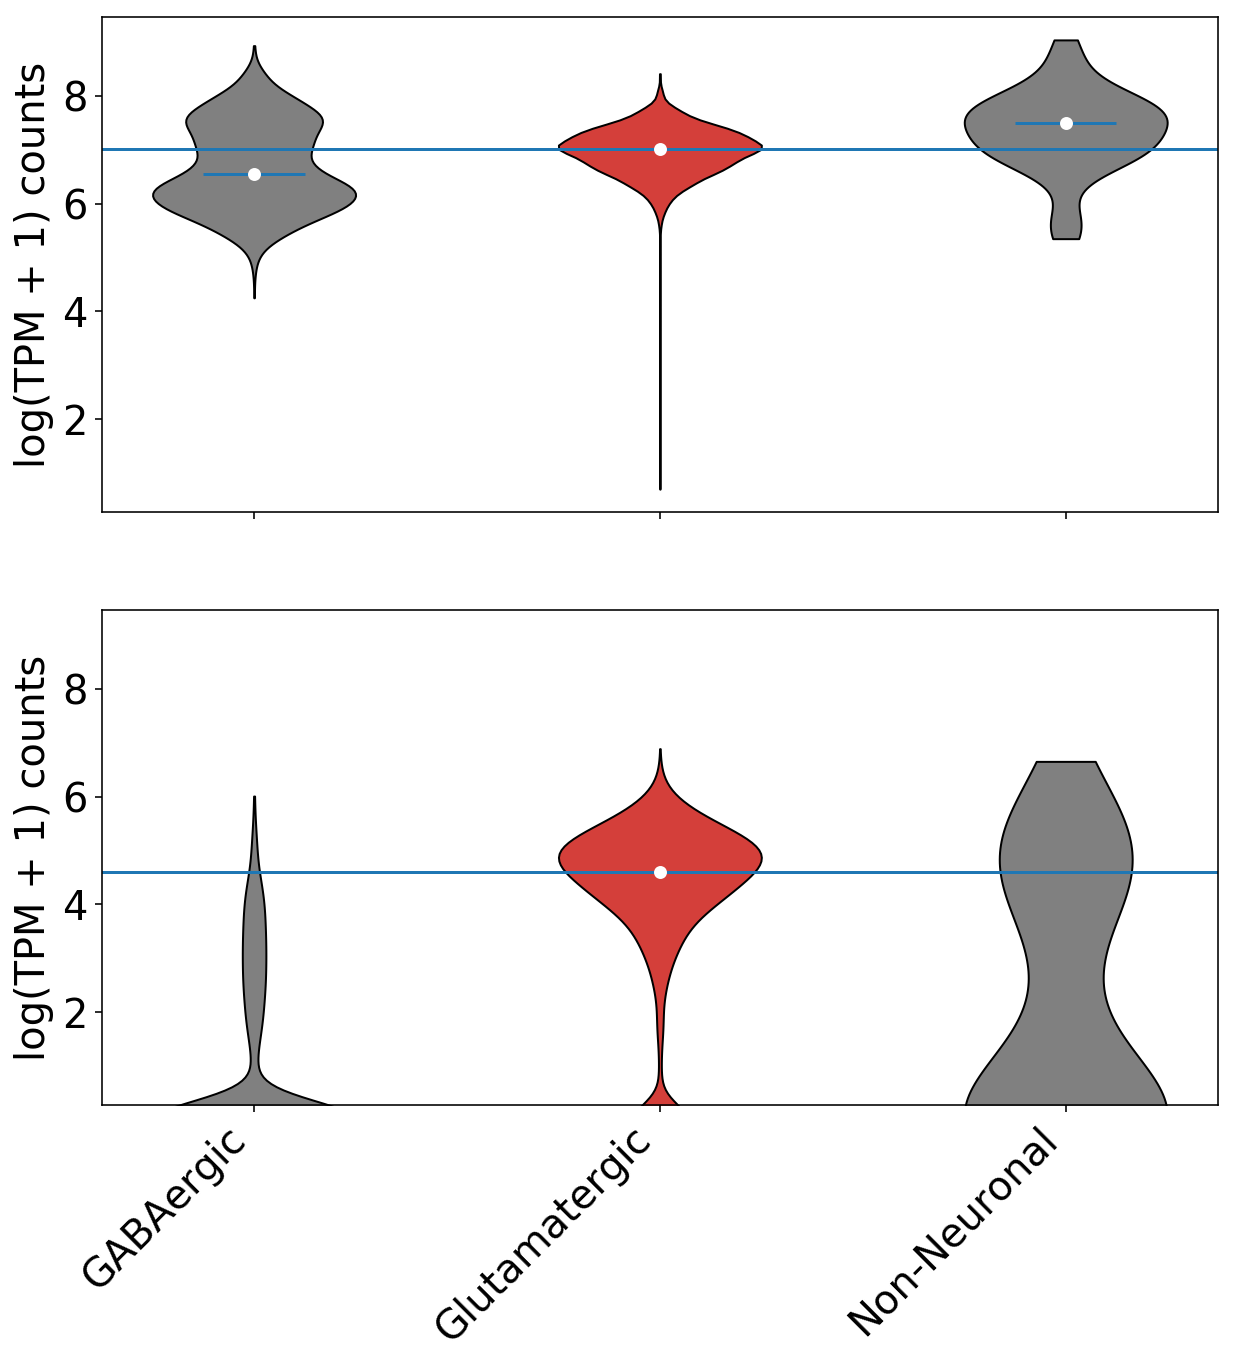

In [285]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2, sharex=True)

unique = np.unique(gene.obs.class_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
#######3# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.class_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"]).reshape(-1).tolist())

parts = ax[0].violinplot(x, showmedians=True, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')

medians = [np.median(i) for i in x]
ax[0].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

ax[0].axhline(y=medians[midx])
ax[0].set_ylabel("log(TPM + 1) counts")
######## Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.class_label==c][:,isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax[1].violinplot(x, showmedians=True, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')

medians = [np.median(i) for i in x]
ax[1].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)
ax[1].axhline(y=medians[midx])
ax[1].set_xticks(lidx)
ax[1].set_xticklabels(labels, rotation=45, ha="right")
ax[1].set_ylabel("log(TPM + 1) counts")
ymin, ymax = ax[0].get_ylim()
ax[1].set_ylim((ymin, ymax))
plt.show()